#2-AMALIY TOPSHIRIQ

#Mavzu: Rekurrent neyron tarmoq (RNN) yordamida vaqt qatorlarini tahlil qilish

#1. Ma’lumotlarni tayyorlash

Vaqt qatori (Time Series) ma’lumotlarini yuklash.

Ma’lumotlarni normalizatsiya qilish va ketma-ketliklarga bo‘lish.

In [ ]:
# ==== SimpleRNN — AirQualityUCI dataset bilan amaliy ish ====

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
df

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.600,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.300,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.900,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.000,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.150,59.575001,0.788794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04,10:00:00,3.1,1314.25,-200,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,29.250000,0.756824
9353,2005-04-04,11:00:00,2.4,1162.50,-200,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,23.725000,0.711864
9354,2005-04-04,12:00:00,2.4,1142.00,-200,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,18.350000,0.640649
9355,2005-04-04,13:00:00,2.1,1002.50,-200,9.547187,960.50,234.5,701.50,155.7,1041.00,769.75,28.325,13.550000,0.513866


In [ ]:
# ==== 1. Konfiguratsiya ====
CFG = {
    "data": {
        "timesteps": 10,    # ketma-ketlik uzunligi
    },
    "model": {
        "units": 32,
        "activation": "tanh",
        "dropout": 0.0,
        "recurrent_dropout": 0.0,
        "use_bias": True
    },
    "train": {
        "optimizer": "adam",
        "learning_rate": 1e-3,
        "epochs": 20,
        "batch_size": 32,
        "val_split": 0.1
    }
}

# ==== 2. Datasetni yuklash ====
df = pd.read_excel("/content/AirQualityUCI.xlsx")

# ==== 3. Tozalash ====
df = df.dropna(axis=1, how="all")   # bo‘sh ustunlarni o‘chir
df = df.dropna(how="any")           # NaN satrlarni o‘chir

# Faqat raqamli ustunlarni olish
df_numeric = df.select_dtypes(include=[np.number])

# -200 qiymatlarini NaN bilan almashtirish
df_numeric = df_numeric.replace(-200, np.nan)

# NaN qiymatlarini ustunning o'rtacha qiymati bilan to'ldirish
# Boshqa usullar ham mavjud (masalan, median, oldingi/keyingi qiymat bilan to'ldirish)
df_numeric = df_numeric.fillna(df_numeric.mean())

print("Raqamli ustunlar:", df_numeric.columns.tolist())
print("Satrlar soni:", df_numeric.shape[0])

# ==== 4. Ma'lumotlarni normalizatsiya qilish ====
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric)

# ==== 5. X va y ni tayyorlash ====
# Masalan, so‘nggi ustun (NOx(GT)) ni target sifatida olamiz
X = scaled_data[:, :-1]
y = scaled_data[:, -1].reshape(-1, 1)

# ==== 6. RNN uchun 3D ketma-ketliklar yaratish ====
T = CFG["data"]["timesteps"]
X_seq, y_seq = [], []
for i in range(len(X) - T):
    X_seq.append(X[i:i+T])
    y_seq.append(y[i+T])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print(f"✅ X_seq shakli: {X_seq.shape}")  # (namunalar, timesteps, xususiyatlar)
print(f"✅ y_seq shakli: {y_seq.shape}")  # (namunalar, 1)

Raqamli ustunlar: ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
Satrlar soni: 9357
✅ X_seq shakli: (9347, 10, 12)
✅ y_seq shakli: (9347, 1)


#2. Modelni yaratish

TensorFlow kutubxonasidan foydalanib LSTM yoki SimpleRNN
modelini yaratish.

Model parametrlarini moslash.

In [ ]:
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM

def get_optimizer(name, lr):
    return Adam(learning_rate=lr) if name.lower() == "adam" else RMSprop(learning_rate=lr)

model = Sequential([
    SimpleRNN( # LSTM o'rniga SimpleRNN ishlatildi
        units=CFG["model"]["units"],
        activation=CFG["model"]["activation"],
        dropout=CFG["model"]["dropout"],
        recurrent_dropout=CFG["model"]["recurrent_dropout"],
        use_bias=CFG["model"]["use_bias"],
        input_shape=(T, X_seq.shape[2])
    ),
    Dense(1)
])

opt = get_optimizer(CFG["train"]["optimizer"], CFG["train"]["learning_rate"])
model.compile(optimizer=opt, loss="mse")
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 32)             │         1,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,473 (5.75 KB)

 Trainable params: 1,473 (5.75 KB)

 Non-trainable params: 0 (0.00 B)

#3. Modelni o‘qitish va baholash

Modelni .fit() yordamida o‘qitish.

Bashorat (prediction) natijalarini olish.

MSE yoki RMSE qiymatini hisoblash.

In [ ]:
from sklearn.model_selection import train_test_split

# Ma'lumotlarni o'quv va test to'plamlariga ajratish
# Masalan, 80% o'quv, 20% test uchun
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, shuffle=False # Vaqt qatorlari uchun shuffle=False muhim
)

# O'quv-validatsiya to'plamini o'quv va validatsiyaga ajratish
# Masalan, X_train_val ning 10% validatsiya uchun (bu umumiy ma'lumotning 8% ga to'g'ri keladi)
val_size = int(len(X_train_val) * CFG["train"]["val_split"])
X_train, X_val = X_train_val[:-val_size], X_train_val[-val_size:]
y_train, y_val = y_train_val[:-val_size], y_train_val[-val_size:]


print(f"X_train shakli: {X_train.shape}")
print(f"y_train shakli: {y_train.shape}")
print(f"X_val shakli: {X_val.shape}")
print(f"y_val shakli: {y_val.shape}")
print(f"X_test shakli: {X_test.shape}")
print(f"y_test shakli: {y_test.shape}")

X_train shakli: (6730, 10, 12)
y_train shakli: (6730, 1)
X_val shakli: (747, 10, 12)
y_val shakli: (747, 1)
X_test shakli: (1870, 10, 12)
y_test shakli: (1870, 1)


In [ ]:
# Modelni o'quv va validatsiya to'plamlarida o'qitish
hist = model.fit(
    X_train, y_train,
    epochs=CFG["train"]["epochs"],
    batch_size=CFG["train"]["batch_size"],
    validation_data=(X_val, y_val), # Validatsiya ma'lumotlarini ko'rsatamiz
    verbose=1
)

# Test to'plamida bashorat
y_pred_test = model.predict(X_test, verbose=0)

# Test to'plamida metrikalarni hisoblash
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test) # Qo'shimcha R^2 metriksini ham hisoblaymiz

print(f"Test to'plamida MSE: {mse_test:.4f}")
print(f"Test to'plamida RMSE: {rmse_test:.4f}")
print(f"Test to'plamida R^2: {r2_test:.4f}")

Epoch 1/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5081 - val_loss: 0.1346
Epoch 2/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1068 - val_loss: 0.1362
Epoch 3/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0766 - val_loss: 0.0812
Epoch 4/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0573 - val_loss: 0.0684
Epoch 5/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0486 - val_loss: 0.0542
Epoch 6/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0425 - val_loss: 0.0432
Epoch 7/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0392 - val_loss: 0.0432
Epoch 8/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0361 - val_loss: 0.0413
Epoch 9/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0325 - val_loss: 0.0281
Epoch 10/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0316 - val_loss: 0.0294
Epoch 11/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0319 - val_loss: 0.0328
Epoch 12/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

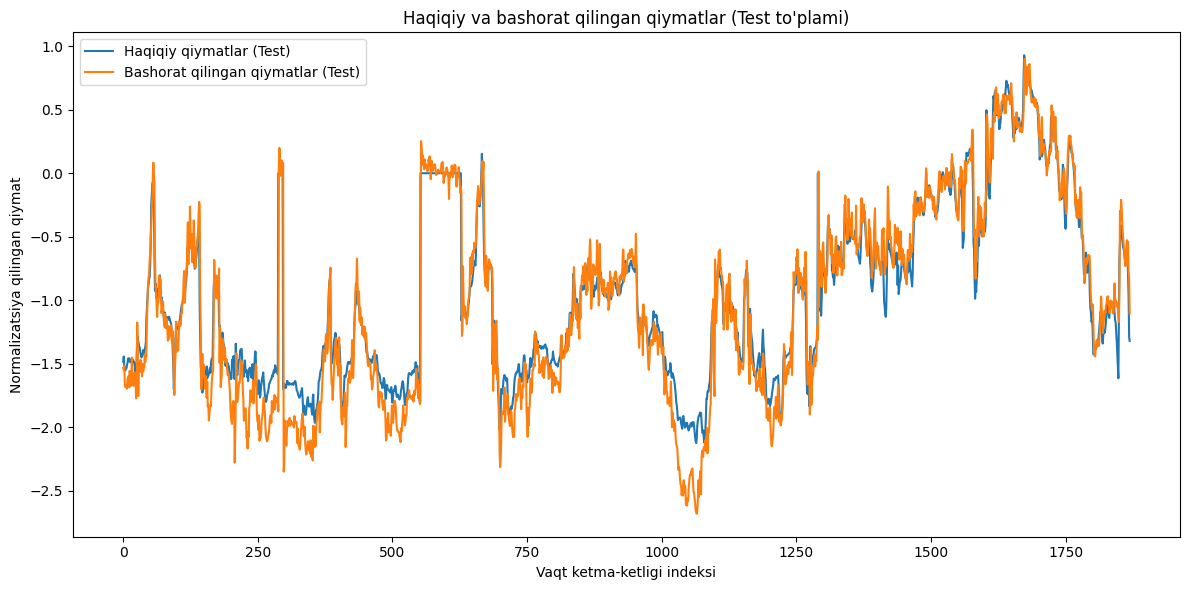

In [ ]:
# Test to'plamidagi haqiqiy va bashorat qilingan qiymatlarni vizualizatsiya qilish
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Haqiqiy qiymatlar (Test)")
plt.plot(y_pred_test, label="Bashorat qilingan qiymatlar (Test)")
plt.title("Haqiqiy va bashorat qilingan qiymatlar (Test to'plami)")
plt.xlabel("Vaqt ketma-ketligi indeksi")
plt.ylabel("Normalizatsiya qilingan qiymat")
plt.legend()
plt.tight_layout()
plt.show()

#4. Natijalarni vizualizatsiya qilish

Haqiqiy va bashorat qilingan qiymatlarni chizish.

Tahliliy grafiklar yaratish.

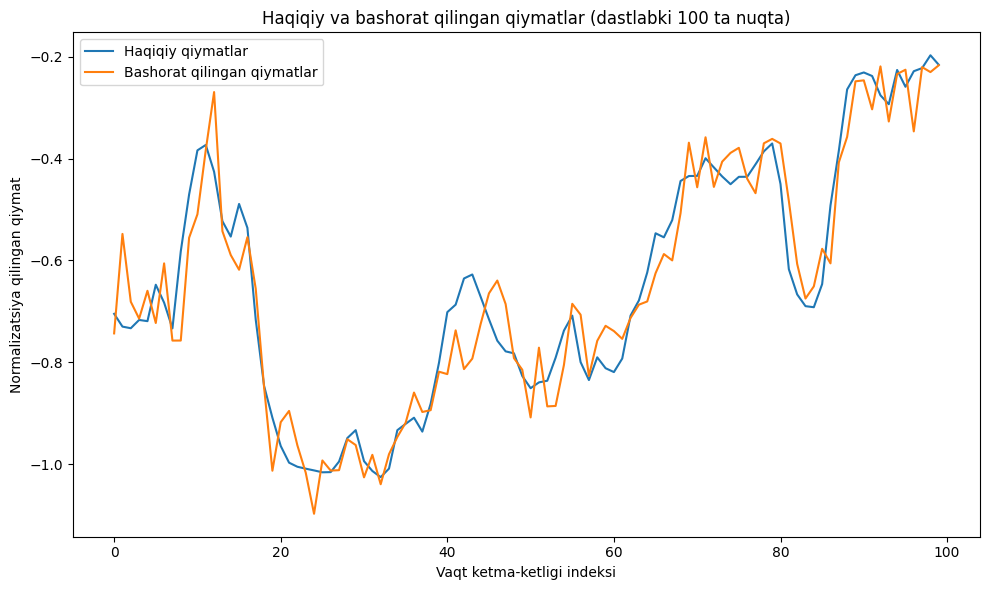

In [ ]:
plt.figure(figsize=(10, 6))
# Dastlabki 100 ta nuqtani ko'rsatish
plt.plot(y_seq[:100], label="Haqiqiy qiymatlar")
plt.plot(y_pred[:100], label="Bashorat qilingan qiymatlar")
plt.title("Haqiqiy va bashorat qilingan qiymatlar (dastlabki 100 ta nuqta)")
plt.xlabel("Vaqt ketma-ketligi indeksi")
plt.ylabel("Normalizatsiya qilingan qiymat")
plt.legend()
plt.tight_layout()
plt.show()

-------------------------------------------------------------------------

LSTM uchun tayyorlangan raqamli ustunlar: ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
LSTM uchun tayyorlangan satrlar soni: 9357
✅ X_seq_lstm shakli: (9347, 10, 12)
✅ y_seq_lstm shakli: (9347, 1)

Ma'lumotlar bo'linmalari shakli (LSTM):
X_train_lstm shakli: (6730, 10, 12)
y_train_lstm shakli: (6730, 1)
X_val_lstm shakli: (747, 10, 12)
y_val_lstm shakli: (747, 1)
X_test_lstm shakli: (1870, 10, 12)
y_test_lstm shakli: (1870, 1)

LSTM Model Summary:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,777 (77.25 KB)

 Trainable params: 19,777 (77.25 KB)

 Non-trainable params: 0 (0.00 B)


LSTM Modelni o'qitish boshlandi...
Epoch 1/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.4612 - val_loss: 0.1126
Epoch 2/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.2125 - val_loss: 0.0818
Epoch 3/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1573 - val_loss: 0.0798
Epoch 4/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1331 - val_loss: 0.0503
Epoch 5/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1218 - val_loss: 0.0343
Epoch 6/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.1085 - val_loss: 0.0252
Epoch 7/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1065 - val_loss: 0.0389
Epoch 8/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1014 - val_loss: 0.0361
Epoch 9/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0985 - val_loss: 0.0614
Epoch 10/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1030 - val_loss: 0.0340
Epoch 11/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0913 - val_loss: 0.0249
Epoch

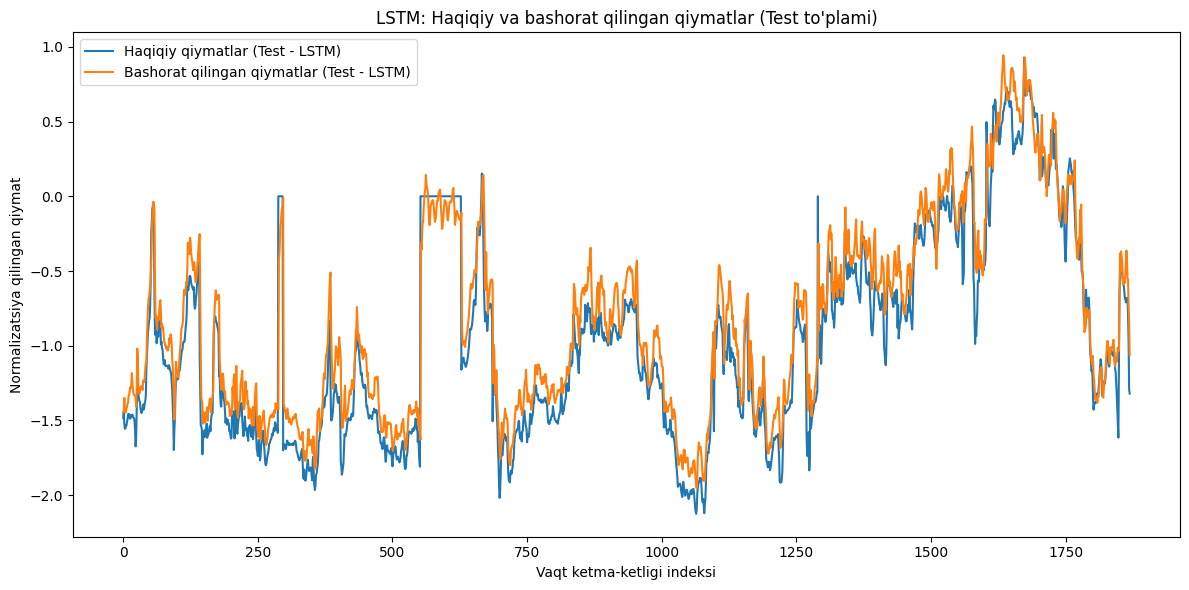

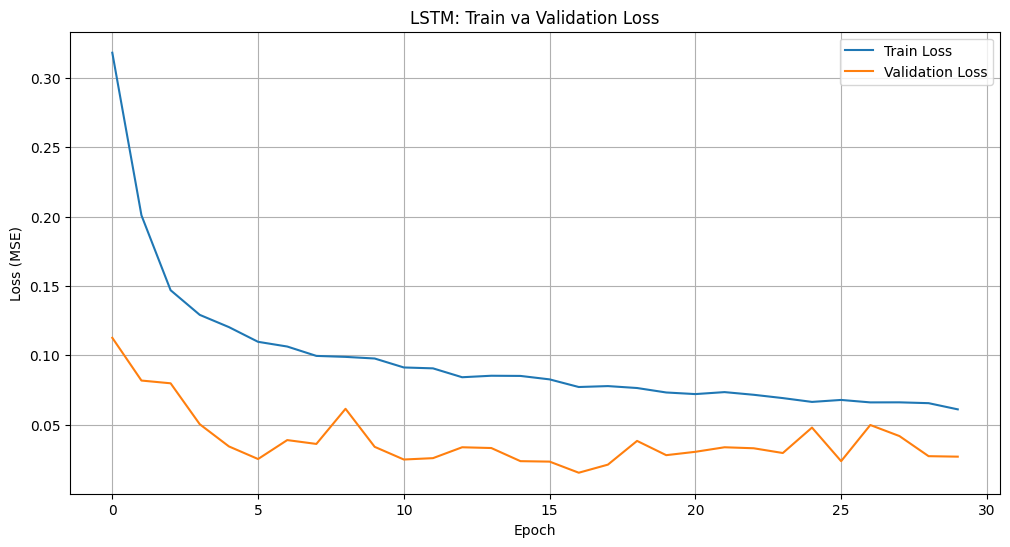

In [ ]:
# ==== LSTM modelini qo'llash uchun to'liq kod ====

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# ==== Konfiguratsiya (LSTM uchun moslashtirilishi mumkin) ====
CFG_LSTM = {
    "data": {
        "timesteps": 10,    # ketma-ketlik uzunligi
    },
    "model": {
        "units": 64, # LSTM uchun ko'proq units ishlatilishi mumkin
        "activation": "tanh",
        "dropout": 0.2, # Overfittingni kamaytirish uchun dropout qo'shildi
        "recurrent_dropout": 0.2,
        "use_bias": True
    },
    "train": {
        "optimizer": "adam",
        "learning_rate": 1e-3,
        "epochs": 30, # Ko'proq epoch kerak bo'lishi mumkin
        "batch_size": 32,
        "val_split": 0.1
    }
}

# ==== Datasetni yuklash ====
df_lstm = pd.read_excel("/content/AirQualityUCI.xlsx")

# ==== Tozalash ====
df_lstm = df_lstm.dropna(axis=1, how="all")   # bo‘sh ustunlarni o‘chir
df_lstm = df_lstm.dropna(how="any")           # NaN satrlarni o‘chir

# Faqat raqamli ustunlarni olish
df_numeric_lstm = df_lstm.select_dtypes(include=[np.number])

# -200 qiymatlarini NaN bilan almashtirish va to'ldirish
df_numeric_lstm = df_numeric_lstm.replace(-200, np.nan)
df_numeric_lstm = df_numeric_lstm.fillna(df_numeric_lstm.mean())

print("LSTM uchun tayyorlangan raqamli ustunlar:", df_numeric_lstm.columns.tolist())
print("LSTM uchun tayyorlangan satrlar soni:", df_numeric_lstm.shape[0])


# ==== Ma'lumotlarni normalizatsiya qilish ====
scaler_lstm = StandardScaler()
scaled_data_lstm = scaler_lstm.fit_transform(df_numeric_lstm)

# ==== X va y ni tayyorlash ====
# Masalan, so‘nggi ustun (NOx(GT)) ni target sifatida olamiz
X_lstm = scaled_data_lstm[:, :-1]
y_lstm = scaled_data_lstm[:, -1].reshape(-1, 1)

# ==== LSTM uchun 3D ketma-ketliklar yaratish ====
T_lstm = CFG_LSTM["data"]["timesteps"]
X_seq_lstm, y_seq_lstm = [], []
for i in range(len(X_lstm) - T_lstm):
    X_seq_lstm.append(X_lstm[i:i+T_lstm])
    y_seq_lstm.append(y_lstm[i+T_lstm])

X_seq_lstm = np.array(X_seq_lstm)
y_seq_lstm = np.array(y_seq_lstm)

print(f"✅ X_seq_lstm shakli: {X_seq_lstm.shape}")  # (namunalar, timesteps, xususiyatlar)
print(f"✅ y_seq_lstm shakli: {y_seq_lstm.shape}")  # (namunalar, 1)

# ==== Ma'lumotlarni o'quv, validatsiya va test to'plamlariga ajratish ====
X_train_val_lstm, X_test_lstm, y_train_val_lstm, y_test_lstm = train_test_split(
    X_seq_lstm, y_seq_lstm, test_size=0.2, random_state=42, shuffle=False
)

val_size_lstm = int(len(X_train_val_lstm) * CFG_LSTM["train"]["val_split"])
X_train_lstm, X_val_lstm = X_train_val_lstm[:-val_size_lstm], X_train_val_lstm[-val_size_lstm:]
y_train_lstm, y_val_lstm = y_train_val_lstm[:-val_size_lstm], y_train_val_lstm[-val_size_lstm:]

print(f"\nMa'lumotlar bo'linmalari shakli (LSTM):")
print(f"X_train_lstm shakli: {X_train_lstm.shape}")
print(f"y_train_lstm shakli: {y_train_lstm.shape}")
print(f"X_val_lstm shakli: {X_val_lstm.shape}")
print(f"y_val_lstm shakli: {y_val_lstm.shape}")
print(f"X_test_lstm shakli: {X_test_lstm.shape}")
print(f"y_test_lstm shakli: {y_test_lstm.shape}")

# ==== LSTM Modelni yaratish ====
model_lstm = Sequential([
    LSTM( # LSTM qatlami ishlatildi
        units=CFG_LSTM["model"]["units"],
        activation=CFG_LSTM["model"]["activation"],
        dropout=CFG_LSTM["model"]["dropout"],
        recurrent_dropout=CFG_LSTM["model"]["recurrent_dropout"],
        use_bias=CFG_LSTM["model"]["use_bias"],
        input_shape=(T_lstm, X_seq_lstm.shape[2])
    ),
    Dense(1)
])

opt_lstm = get_optimizer(CFG_LSTM["train"]["optimizer"], CFG_LSTM["train"]["learning_rate"])
model_lstm.compile(optimizer=opt_lstm, loss="mse")
print("\nLSTM Model Summary:")
model_lstm.summary()

# ==== Modelni o'qitish ====
print("\nLSTM Modelni o'qitish boshlandi...")
hist_lstm = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=CFG_LSTM["train"]["epochs"],
    batch_size=CFG_LSTM["train"]["batch_size"],
    validation_data=(X_val_lstm, y_val_lstm),
    verbose=1
)
print("LSTM Modelni o'qitish yakunlandi.")

# ==== Modelni baholash (Test to'plamida) ====
print("\nLSTM Modelni Test to'plamida baholash...")
y_pred_test_lstm = model_lstm.predict(X_test_lstm, verbose=0)

mse_test_lstm = mean_squared_error(y_test_lstm, y_pred_test_lstm)
rmse_test_lstm = np.sqrt(mse_test_lstm)
r2_test_lstm = r2_score(y_test_lstm, y_pred_test_lstm)

print(f"Test to'plamida (LSTM) MSE: {mse_test_lstm:.4f}")
print(f"Test to'plamida (LSTM) RMSE: {rmse_test_lstm:.4f}")
print(f"Test to'plamida (LSTM) R^2: {r2_test_lstm:.4f}")


# ==== Natijalarni vizualizatsiya qilish (Test to'plami) ====
plt.figure(figsize=(12, 6))
plt.plot(y_test_lstm, label="Haqiqiy qiymatlar (Test - LSTM)")
plt.plot(y_pred_test_lstm, label="Bashorat qilingan qiymatlar (Test - LSTM)")
plt.title("LSTM: Haqiqiy va bashorat qilingan qiymatlar (Test to'plami)")
plt.xlabel("Vaqt ketma-ketligi indeksi")
plt.ylabel("Normalizatsiya qilingan qiymat")
plt.legend()
plt.tight_layout()
plt.show()

# O'qitish jarayonidagi yo'qotish (loss) metrikasini vizualizatsiya qilish
plt.figure(figsize=(12, 6))
plt.plot(hist_lstm.history['loss'], label='Train Loss')
plt.plot(hist_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM: Train va Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()